This code is to explore how having good initial weights can place the neural networks close to the optimal solution

In [1]:
import torch
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

In [2]:
torch.cuda.is_available()

True

In [3]:
# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 100
# percentage of training set to use as validation
valid_size = 0.2

In [4]:
# convert data to torch.FloatTensor
transform = transforms.ToTensor()

# choose the training and test datasets
train_data = datasets.FashionMNIST(root='~/datasets/F_MNIST_data', train=True,
                                   download=True, transform=transform)
test_data = datasets.FashionMNIST(root='~/datasets/F_MNIST_data', train=False,
                                  download=True, transform=transform)

In [5]:
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

In [6]:
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

In [7]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers)

In [8]:
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
    'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

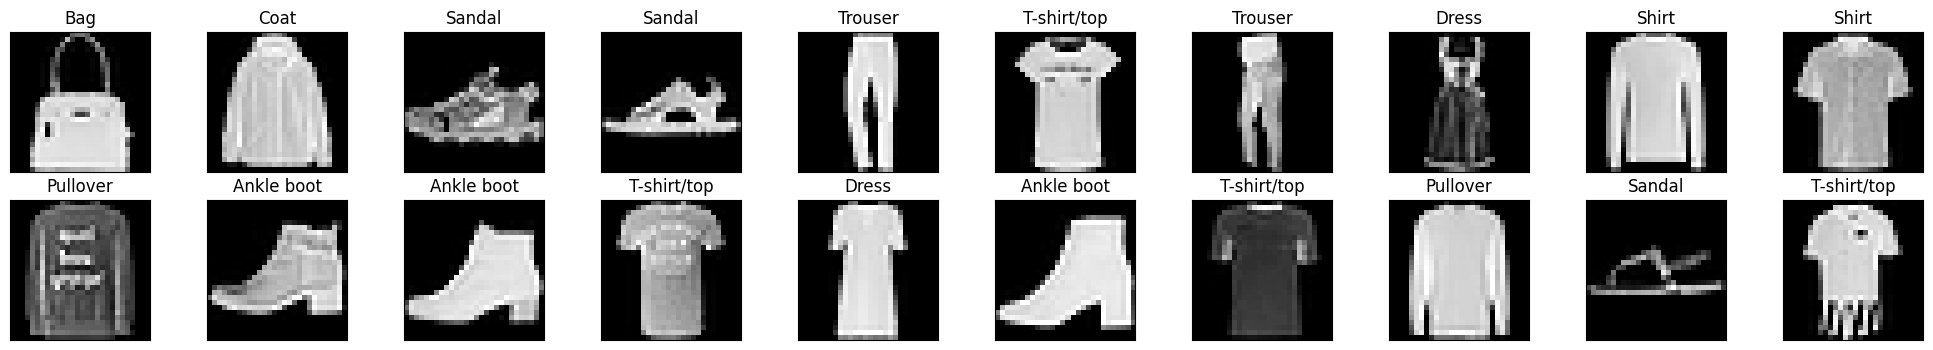

In [9]:
# visualize some data

import matplotlib.pyplot as plt
%matplotlib inline
    
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
images = images.numpy()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20//2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title(classes[labels[idx]])

In [10]:
# define the model
# we can pass the weight using constant weight when we instatiate the model

# define an MLP of 3 layers with hidden dimensions of 256 and 128 and predict the 10 classes


import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):

    def __init__(self, constant_weight=None):
          
        super(Net, self).__init__()

        self.fc1 = nn.Linear(28 * 28, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)

        self.dropout = nn.Dropout(0.3)

        # instatiate the weights to a specified constant value

        if(constant_weight is not None):
            for m in self.modules():

                if isinstance(m, nn.Linear):
                    nn.init.constant_(m.weight, constant_weight)
                    nn.init.constant_(m.bias, 0)

    def forward(self, x):

        x = x.view(-1, 28*28)

        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)

        return x

In [11]:
train_on_gpu = torch.cuda.is_available()

print(train_on_gpu)    
if train_on_gpu:
        print("Training using the GPU")

True
Training using the GPU


In [17]:
def _get_loss_acc(model, train_loader, valid_loader):
    """
    Get losses and validation accuracy of example neural network
    """
    n_epochs = 2
    learning_rate = 0.001
    
    # Training loss
    criterion = nn.CrossEntropyLoss()

    # Optimizer
    optimizer = optimizer = torch.optim.Adam(model.parameters(), learning_rate)

    # Measurements used for graphing loss
    loss_batch = []

    train_on_gpu = torch.cuda.is_available()
    
    if train_on_gpu:
        print("Training using the GPU")

    for epoch in range(1, n_epochs+1):
        # initialize var to monitor training loss
        train_loss = 0.0
        ###################
        # train the model #
        ###################
        model.train()
        for data, target in train_loader:

            if train_on_gpu:
                data, target = data.cuda(), target.cuda()

            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # record average batch loss 
            loss_batch.append(loss.item())
             
    # after training for 2 epochs, check validation accuracy 
    correct = 0
    total = 0
    model.eval()
    for data, target in valid_loader:
        # forward pass: compute predicted outputs by passing inputs to the model
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        output = model(data)
        # get the predicted class from the maximum class score
        _, predicted = torch.max(output.data, 1)
        # count up total number of correct labels
        # for which the predicted and true labels are equal
        total += target.size(0)
        correct += (predicted == target).sum()
      
    # calculate the accuracy
    # to convert `correct` from a Tensor into a scalar, use .item()
    valid_acc = correct.item() / total

    # return model stats
    return loss_batch, valid_acc

In [13]:
# compare training and validation loss for models defined in the model list

def compare_init_weights(
        model_list,
        plot_title,
        train_loader,
        valid_loader,
        plot_n_batches=100):
    """
    Plot loss and print stats of weights using an example neural network
    """
    colors = ['r', 'b', 'g', 'c', 'y', 'k']
    label_accs = []
    label_loss = []

    assert len(model_list) <= len(colors), 'Too many initial weights to plot'

    for i, (model, label) in enumerate(model_list):
        loss, val_acc = _get_loss_acc(model, train_loader, valid_loader)

        plt.plot(loss[:plot_n_batches], colors[i], label=label)
        label_accs.append((label, val_acc))
        label_loss.append((label, loss[-1]))

    plt.title(plot_title)
    plt.xlabel('Batches')
    plt.ylabel('Loss')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()

    print('After 2 Epochs:')
    print('Validation Accuracy')
    for label, val_acc in label_accs:
        print('  {:7.3f}% -- {}'.format(val_acc*100, label))
    print('Training Loss')
    for label, loss in label_loss:
        print('  {:7.3f}  -- {}'.format(loss, label))

In [14]:
def hist_dist(title, distribution_tensor, hist_range=(-4, 4)):
    """
    Display histogram of values in a given distribution tensor
    """
    plt.title(title)
    plt.hist(distribution_tensor, np.linspace(*hist_range, num=len(distribution_tensor)//2))
    plt.show()

In [18]:
# initialize two NN's with 0 and 1 constant weights
model_0 = Net(constant_weight=0)
model_1 = Net(constant_weight=1)

if train_on_gpu:
    model_0 = model_0.cuda()
    model_1 = model_1.cuda()


Training using the GPU
Training using the GPU


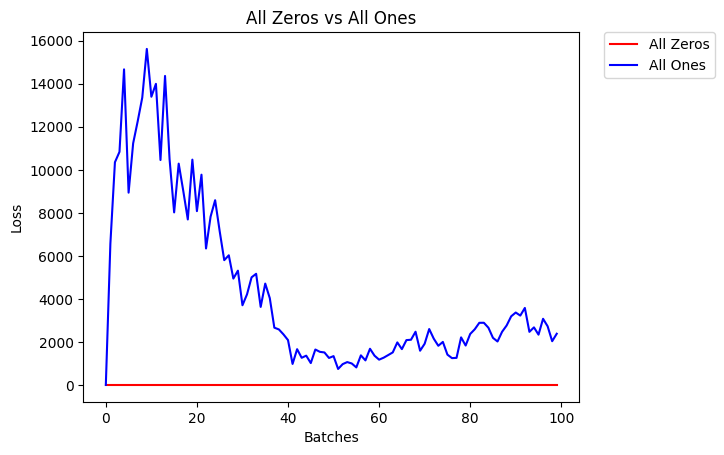

After 2 Epochs:
Validation Accuracy
    9.808% -- All Zeros
   10.150% -- All Ones
Training Loss
    2.303  -- All Zeros
  491.007  -- All Ones


In [19]:
model_list = [(model_0, 'All Zeros'),
              (model_1, 'All Ones')]

compare_init_weights(model_list, 
                             'All Zeros vs All Ones', 
                             train_loader,
                             valid_loader)

The neural networks are having a hard time to learn when they have a constant weight as the neurons have the same output in a layer. 

So, which neuron to change and by how much? This is difficult. 

One way is to set random weights

One solution is to set these random weights using an uniform distribution

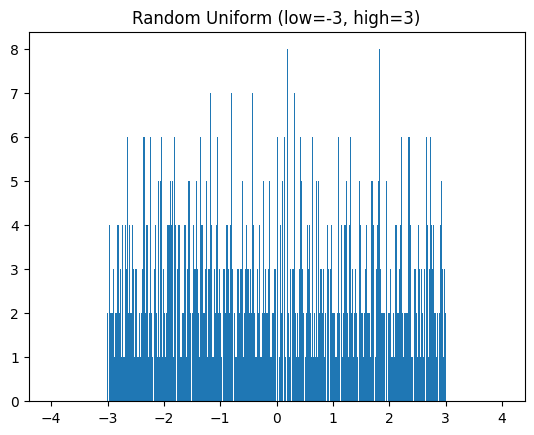

In [20]:
hist_dist('Random Uniform (low=-3, high=3)', np.random.uniform(-3, 3, [1000]))

In [21]:
# to define weights outside the model definition, we can apply weights to an initialized model using model.apply(fn)

def weights_init_uniform(m):
    classname = m.__class__.__name__
    # for every Linear layer in a model..
    if classname.find('Linear') != -1:
        # apply a uniform distribution to the weights and a bias=0
        m.weight.data.uniform_(0.0, 1.0)
        m.bias.data.fill_(0)

In [22]:
model_uniform = Net()

if train_on_gpu:
    model_uniform = model_uniform.cuda()

model_uniform.apply(weights_init_uniform)

Net(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

Training using the GPU


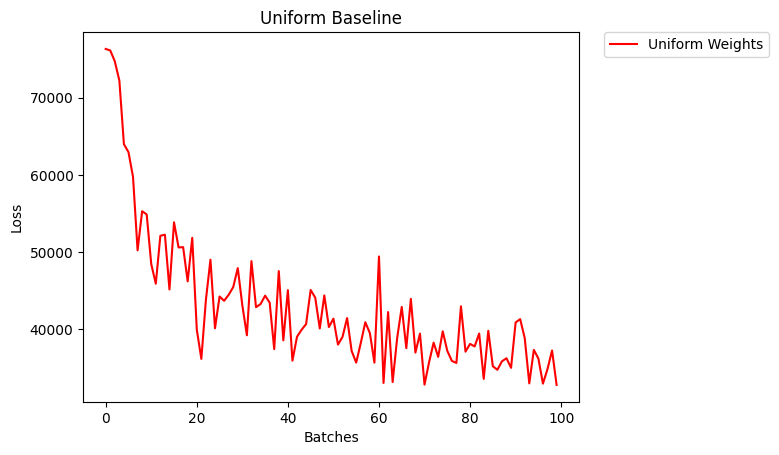

After 2 Epochs:
Validation Accuracy
   30.733% -- Uniform Weights
Training Loss
   10.740  -- Uniform Weights


In [23]:
compare_init_weights([(model_uniform, 'Uniform Weights')], 
                             'Uniform Baseline', 
                             train_loader,
                             valid_loader)

The loss graph tells us that the netowrk is learning - the loss is reducing

This didnt happen wiht constant weight initialization. 

General rule to set weights: 

1. Set the weights close to zero but not too small
2. Good practice is to start your weights in the range of [-y, y] where y = 1/sqrt(n)
( n is the number of inputs to a given neuron)

In [24]:
#  for 1. setting close to zero
def weights_init_uniform_center(m):
    classname = m.__class__.__name__
    # for every Linear layer in a model..
    if classname.find('Linear') != -1:
        # apply a centered, uniform distribution to the weights
        m.weight.data.uniform_(-0.5, 0.5)
        m.bias.data.fill_(0)

In [25]:
model_centered = Net()

if train_on_gpu:
    model_centered = model_centered.cuda()

model_centered.apply(weights_init_uniform_center)

Net(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

In [26]:
# for 2. setting weights in range [-y, y] where y = 1/sqrt(n) , n = no. of inputs to a given neuron

def weights_init_uniform_rule(m):
    classname = m.__class__.__name__
    # for every Linear layer in a model..
    if classname.find('Linear') != -1:
        # get the number of the inputs
        n = m.in_features
        y = 1.0/np.sqrt(n)
        m.weight.data.uniform_(-y, y)
        m.bias.data.fill_(0)


In [27]:
model_rule = Net()

if train_on_gpu:
    model_rule = model_rule.cuda()
model_rule.apply(weights_init_uniform_rule)

Net(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

Training using the GPU
Training using the GPU


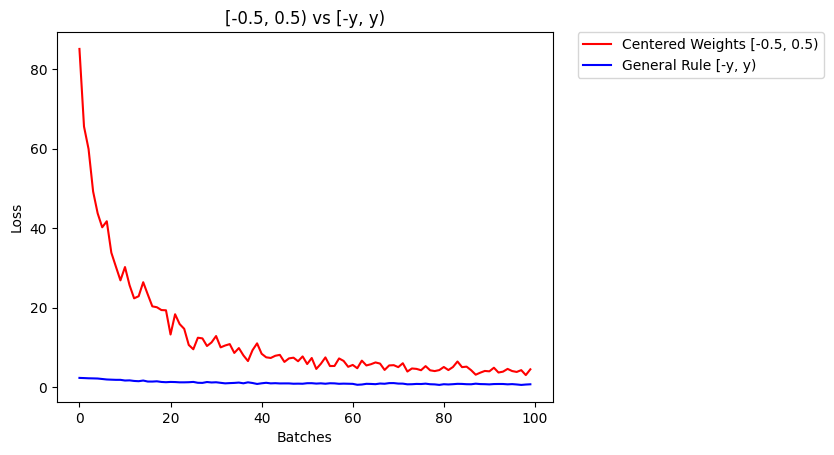

After 2 Epochs:
Validation Accuracy
   79.742% -- Centered Weights [-0.5, 0.5)
   86.067% -- General Rule [-y, y)
Training Loss
    0.807  -- Centered Weights [-0.5, 0.5)
    0.304  -- General Rule [-y, y)


In [28]:
model_list = [(model_centered, 'Centered Weights [-0.5, 0.5)'), 
              (model_rule, 'General Rule [-y, y)')]

# evaluate behavior 
compare_init_weights(model_list, 
                             '[-0.5, 0.5) vs [-y, y)', 
                             train_loader,
                             valid_loader)               

The loss is reducing and also reducing very fast!

Thus using the right weights can help us in our training process

Since we want it to be close to zero, instead of uniform distribution, we can try using a  normal distribution

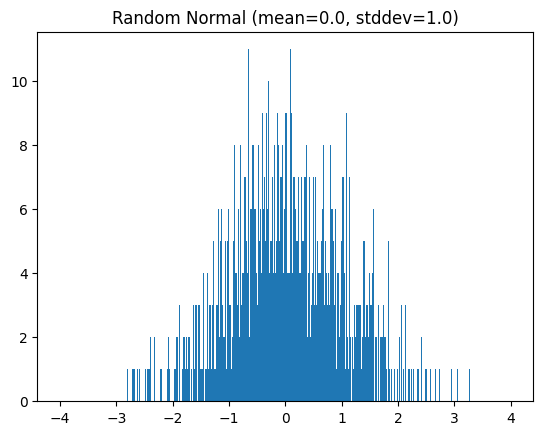

In [29]:
hist_dist('Random Normal (mean=0.0, stddev=1.0)', np.random.normal(size=[1000]))

In [30]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    # for every Linear layer in a model..
    if classname.find('Linear') != -1:
        # get the number of the inputs
        n = m.in_features
        y = (1.0/np.sqrt(n))
        m.weight.data.normal_(0, y)
        m.bias.data.fill_(0)

In [32]:
# uniform distribution
model_uniform_rule = Net()

if train_on_gpu:
    model_uniform_rule = model_uniform_rule.cuda()

model_uniform_rule.apply(weights_init_uniform_rule)

# normal distribution
model_normal_rule = Net()

if train_on_gpu:
    model_normal_rule = model_normal_rule.cuda()
    
model_normal_rule.apply(weights_init_normal)

Net(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

In [33]:
model_list = [(model_uniform_rule, 'Uniform Rule [-y, y)'), 
              (model_normal_rule, 'Normal Distribution')]

Training using the GPU
Training using the GPU


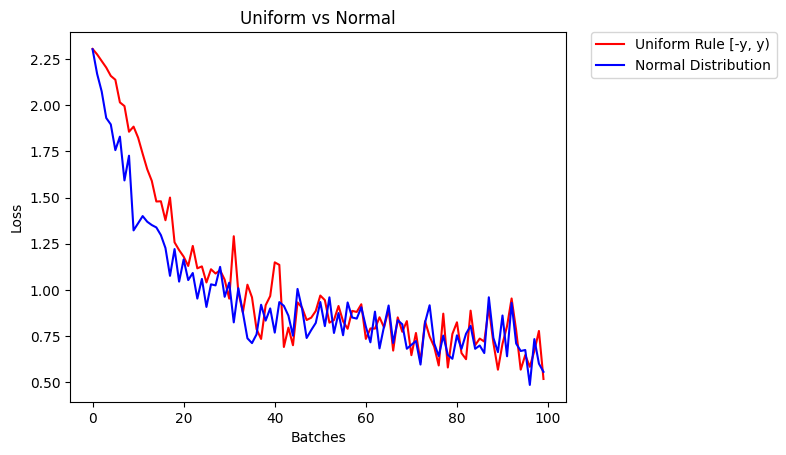

After 2 Epochs:
Validation Accuracy
   84.733% -- Uniform Rule [-y, y)
   86.233% -- Normal Distribution
Training Loss
    0.386  -- Uniform Rule [-y, y)
    0.377  -- Normal Distribution


In [34]:
compare_init_weights(model_list, 
                             'Uniform vs Normal', 
                             train_loader,
                             valid_loader)

The outputs are very similar - most likely because the network is small

In general - normal distribution gives better results

### PyTorch has default weight initialization behavior for every kind of layer. 

### The linear layers are initialized with a uniform distribution